In [1]:
import pandas as pd
import numpy as np
import datetime
import pingouin as pg
from scipy.stats import bootstrap
from scipy.stats import chi2_contingency
from scipy.stats import norm
from tqdm.auto import tqdm
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

### Проведен А/В тест: 
для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

**Задания:**
1. Был ли эксперимент успешен в целом.   
Как понять, что эксперимент прошел успешно? Можно предположить, что в результате увеличилась выручка с каналов новых платежных систем и увеличилось количество пользователей,которые использовали новую систему оплаты. 
2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

**Целевая метрика:** выручка при оформлении премиум-подписки через новые платежные системы   
**Нулевая гипотеза:** в обеих группах нет различий между выручкой через новые платежные системы и через старую.

**Альтернативная гипотеза:** выручка от оформления премиум-подписки через новые платежные системы выше в тестовой группе, по сравнению с контрольной

ИЛИ в тестовой группе больше пользователей, оформивших премиум-подписку через новые платежные системы.  

### Информация о пользователях:

- `uid` – идентификатор пользователя    
- `age` – возраст   
- `attraction_coeff` – коэффициент привлекательности (от 0 до 1000, лайки/просмотры*1000)
- `coins` – число монеток (внутренняя валюта)  
- `country` – страна    
- `visit_days` – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)  
- `gender` – пол  
- `age_filter_start`  – фильтр поиска, мин. значение   
- `age_filter_end`  – фильтр поиска, макс. значение   
- `views_count` – число полученных оценок    
- `was_premium` – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)   
- `is_premium` –  является ли премиум 
- `total_revenue` – нормированная выручка   

### Информация о платежах пользователей:

- `uid` – идентификатор пользователя  
- `country` – страна  
- `joined_at` – дата и время регистрации  
- `paid_at` – дата и время покупки  
- `revenue` – нормированная выручка  
- `payment_id` – идентификатор платежа  
- `from_page` – откуда пользователь перешел на страницу оплаты  
- `product_type` – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)   

### Предобработка данных
Считаем данные, проверим наличие пустых значений, дубликатов, типы данных.


In [2]:
users_control_1 = pd.read_csv('Проект_3_users_control_1.csv', sep = ';')
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [3]:
#информация
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [4]:
#наличие пустых значений
users_control_1.isna().sum()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Пустые значения имеются в колонках монеток, дней посещения приложения, информации о премиум-статусе. 


In [5]:
#заполним пустые значения нулями
users_control_1.fillna(0, inplace=True)

In [6]:
#наличие дубликатов
users_control_1.duplicated().sum()

0

In [7]:
transactions_control_1 = pd.read_csv('Проект_3_transactions_control_1.csv', sep = ';', parse_dates=['joined_at','paid_at'], dayfirst=True)
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [8]:
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 63.1+ KB


Колонка "uid" имеет тип данных float, колонки с датами первоначально имели тип object, поэтому при импортировании файла был добавлен аргумент "parse_dates"

In [9]:
#наличие дубликатов
transactions_control_1.duplicated().sum()

650

In [10]:
transactions_control_1.drop_duplicates(inplace=True)

In [11]:
transactions_control_1.isna().sum()

uid             1
country         1
joined_at       1
paid_at         1
revenue         1
payment_id      1
from_page       1
product_type    1
dtype: int64

In [12]:
#удалим строку, где все значения пустые
transactions_control_1.dropna(how='all', inplace=True)

In [13]:
# поменяем тип данных в колонке с id пользователя
transactions_control_1['uid'] = transactions_control_1['uid'].astype(int)

In [14]:
transactions_control_1.shape

(356, 8)

После предобработки данных датафрейм с транзакциями сократился с 1007 строк до 356

In [15]:
#Объединим датафреймы с информацией о пользователях и о платежах
df_control_1 = users_control_1.merge(transactions_control_1, how = 'left', on=['uid', 'country'])
df_control_1.head() 

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892319115,25,435,0.0,United States of America,"1,2,3,4,5,6",0,22,32,982,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,NaN
1,891248523,29,500,0.0,United States of America,"1,2",1,26,32,12,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,NaN
2,891670932,33,800,0.0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,NaN
3,891060786,26,0,0.0,Argentina,"1,2,3,4,5",1,23,29,0,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,NaN
4,892006554,35,294,0.0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,NaN


In [16]:
#добавим номер группы
df_control_1['group']='1'
df_control_1.head(1)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,892319115,25,435,0.0,United States of America,"1,2,3,4,5,6",0,22,32,982,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,NaN,1


In [17]:
# размер получившегося датафрейма
df_control_1.shape

(4503, 20)

In [18]:
#сходятся ли датафреймы по размерам
users_control_1.shape[0] + transactions_control_1.shape[0]

4696

В получившемся датафрейме меньше строк, чем в исходных. Это может быть связано с тем, что есть пользователи, которые неоднократно совершали покупки в приложении - продлевали премиум-подписку. Попробуем это проверить, посмотрев на наличие дубликатов в id пользователей.

In [19]:
df_control_1.uid.duplicated().sum()

163

In [20]:
#выведем дубликаты, это пользователи, которые платили несколько раз
duplicated_uid= df_control_1[df_control_1.uid.duplicated ()]
duplicated_uid.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
6,891497961,28,400,28.0,Chile,"1,2",1,25,31,25,0.0,0.0,6396,2017-02-11 15:07:00,2017-04-11 02:25:00,3978.0,146.0,empty_likes,coins,1
189,891264903,19,239,0.0,United States of America,"2,3,4,5,6,7,8,9",1,16,22,46,1.0,1.0,7761,2017-06-11 16:02:00,2017-09-11 10:32:00,3874.0,147.0,none,premium_no_trial,1
262,891367521,25,129,1.0,Italy,"1,2,3,5,6,7,8",1,16,99,62,1.0,0.0,20462,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,19.0,sympathy,other_type,1
263,891367521,25,129,1.0,Italy,"1,2,3,5,6,7,8",1,16,99,62,1.0,0.0,20462,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,19.0,coins_popup,other_type,1
264,891367521,25,129,1.0,Italy,"1,2,3,5,6,7,8",1,16,99,62,1.0,0.0,20462,2017-05-11 02:37:00,2017-06-11 17:43:00,1456.0,19.0,sympathy,other_type,1


In [21]:
if df_control_1.shape[0] - df_control_1.uid.duplicated().sum() == users_control_1.uid.nunique():
    print('Значения совпадают.')
else:
    print('Значения не совпадают, где-то ошибка.')

Значения совпадают.


In [22]:
#вторая контрольная группа
users_control_2 = pd.read_csv('Проект_3_users_control_2.csv', sep = ';')
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [23]:
#информация
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [24]:
users_control_2.duplicated().sum()

0

In [25]:
users_control_2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

In [26]:
#заполним пустые значения нулями
#users_control_2.fillna(0, inplace=True)

In [27]:
transactions_control_2 = pd.read_csv('Проект_3_transactions_control_2.csv', sep = ';', parse_dates=['joined_at','paid_at'], dayfirst=True)
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [28]:
#информация
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           328 non-null    int64         
 1   country       328 non-null    object        
 2   joined_at     328 non-null    datetime64[ns]
 3   paid_at       328 non-null    datetime64[ns]
 4   revenue       328 non-null    int64         
 5   payment_id    328 non-null    int64         
 6   from_page     328 non-null    object        
 7   product_type  328 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 20.6+ KB


In [29]:
# наличие дубликатов
transactions_control_2.duplicated().sum()

5

In [30]:
#удаление дубликатов
transactions_control_2.drop_duplicates(inplace=True)

In [31]:
#наличие пустых значений
transactions_control_2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [32]:
#объединение данных о второй контрольной группе
df_control_2 = users_control_2.merge(transactions_control_2, how = 'left', on=['uid', 'country'])
df_control_2.head() 

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0,NaT,NaT,NaN,NaN,NaN,NaN
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0,NaT,NaT,NaN,NaN,NaN,NaN
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0,NaT,NaT,NaN,NaN,NaN,NaN
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0,NaT,NaT,NaN,NaN,NaN,NaN
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0,NaT,NaT,NaN,NaN,NaN,NaN


In [33]:
#колонка с номером группы
df_control_2['group']='2'
df_control_2.head(1)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0,NaT,NaT,NaN,NaN,NaN,NaN,2


In [34]:
df_control_2.shape

(4400, 20)

In [35]:
#сходятся ли датафреймы по размерам
users_control_2.shape[0] + transactions_control_2.shape[0]

4587

In [36]:
# Опять не сходятся, также посчитаем дубликаты uid в новом датасете и вычтем их 
if df_control_2.shape[0] - df_control_2.uid.duplicated().sum() == users_control_2.uid.nunique():
    print('Значения совпадают.')
else:
    print('Значения не совпадают, где-то ошибка.')

Значения совпадают.


In [37]:
#объединим датафреймы контрольных групп
df_control = pd.concat([df_control_1, df_control_2], ignore_index= True)

In [38]:
#данные тестовой группы
users_test = pd.read_csv('Проект_3_users_test.csv', sep = ';')
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [39]:
#информация
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


In [40]:
#наличие дубликатов
users_test.duplicated().sum()

0

In [41]:
#наличие пустых значений
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [42]:
#заполним пустые значения нулями
#users_test.fillna(0, inplace=True)

In [43]:
# данные о транзакция в тестовой группе
transactions_test = pd.read_csv('Проект_3_transactions_test.csv', sep = ';', parse_dates=['joined_at','paid_at'], dayfirst=True)
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [44]:
#информация
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           273 non-null    int64         
 1   country       273 non-null    object        
 2   joined_at     273 non-null    datetime64[ns]
 3   paid_at       273 non-null    datetime64[ns]
 4   revenue       273 non-null    int64         
 5   payment_id    273 non-null    int64         
 6   from_page     273 non-null    object        
 7   product_type  273 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 17.2+ KB


In [45]:
#наличие дубликатов
transactions_test.duplicated().sum()

7

In [46]:
#удаление дубликатов
transactions_test.drop_duplicates(inplace=True)

In [47]:
transactions_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [48]:
#объединение данных тестовой группы
df_test = users_test.merge(transactions_test, how = 'left', on=['uid', 'country'])
df_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,NaT,NaT,NaN,NaN,NaN,NaN
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,NaT,NaT,NaN,NaN,NaN,NaN
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,NaT,NaT,NaN,NaN,NaN,NaN
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,NaT,NaT,NaN,NaN,NaN,NaN
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,NaT,NaT,NaN,NaN,NaN,NaN


In [49]:
#добавление названия группы
df_test['group']='test'
df_test.head(1)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,NaT,NaT,NaN,NaN,NaN,NaN,test


In [50]:
df_test.shape

(4428, 20)

In [51]:
#сходятся ли датафреймы по размерам
users_test.shape[0] + transactions_test.shape[0]

4574

In [52]:
if df_test.shape[0] - df_test.uid.duplicated().sum() == users_test.uid.nunique():
    print('Значения совпадают.')
else:
    print('Значения не совпадают, где-то ошибка.')

Значения совпадают.


In [53]:
#создание общего датасета
df = pd.concat([df_control, df_test], ignore_index= True)
df.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,892319115,25,435,0.0,United States of America,"1,2,3,4,5,6",0,22,32,982,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,NaN,1
1,891248523,29,500,0.0,United States of America,"1,2",1,26,32,12,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,NaN,1
2,891670932,33,800,0.0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,NaN,1
3,891060786,26,0,0.0,Argentina,"1,2,3,4,5",1,23,29,0,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,NaN,1
4,892006554,35,294,0.0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,0.0,0.0,0,NaT,NaT,NaN,NaN,NaN,NaN,1


In [54]:
df.shape

(13331, 20)

После объединения в датафрейме получилось очень много пустых значений - ведь не все пользователи покупали премиум подписку, кто-то даже не заходил в приложение после регистрации. 
Нужно решить, оставить пустые значения, или убрать все строки о пользователях, кто ничего не платил. Так как нам даны результаты уже проведенного теста, и предлагается только провести его оценку (полезна новая фича или нет), удалять пустые строки было бы некорректно. Поэтому заменим все пустые значения, кроме дат, на 0

In [55]:
#замена пустых значений на 0
#df[['coins', 'visit_days', 'was_premium', 'is_premium', 'revenue', 'payment_id', 'from_page', 'product_type']]=df[['coins', 'visit_days', 'was_premium', 'is_premium', 'revenue', 'payment_id', 'from_page', 'product_type']].fillna(0)

In [56]:
#описательные статистики
df.describe().T.drop(["uid", "gender", "was_premium", "is_premium", "payment_id"], axis=0).style.background_gradient(subset=["mean", "50%"], cmap='mako_r')

,count,mean,std,min,25%,50%,75%,max
age,13331.000000,32.026555,10.349354,16.000000,25.000000,30.000000,38.000000,99.000000
attraction_coeff,13331.000000,314.864451,319.627002,0.000000,0.000000,250.000000,518.000000,1000.000000
coins,4814.000000,81.870586,2507.626708,0.000000,0.000000,0.000000,0.000000,99958.000000
age_filter_start,13331.000000,26.711274,9.396555,13.000000,19.000000,24.000000,32.000000,96.000000
age_filter_end,13331.000000,38.536869,15.468034,19.000000,28.000000,35.000000,45.000000,102.000000
views_count,13331.000000,55.634836,301.131132,0.000000,1.000000,6.000000,24.000000,16157.000000
total_revenue,13331.000000,1887.372590,19394.084572,0.000000,0.000000,0.000000,0.000000,486330.000000
revenue,945.000000,7127.012698,8689.031007,26.000000,2730.000000,6292.000000,9087.000000,113477.000000


In [57]:
df.describe(include='object')

,country,visit_days,from_page,product_type,group
count,13331,10635,945,945,13331
unique,72,2133,28,4,3
top,United States of America,1,empty_likes,coins,1
freq,4525,1710,254,358,4503


### Выводы предобработки данных   
1.    
2. В данных о транзакциях были удалены дублированные записи (1 группа - 650 записей, 2 группа - 5, тестовая группа - 7)   
3. В данных transaction_1 колонка "uid" имела тип данных float - заменено на int   
4. Были изменены типы данных для дат   
5. Датафреймы были объединены по группам, соединены в один, добавлены колонки с названием группы  

Для того, чтобы понять, был ли успешен эксперимент в целом, нужно определить целевую аудиторию приложения.


In [58]:
#Кто вообще пользуется приложением
gender=df.groupby('gender', as_index=False)\
.agg({'uid': 'nunique'})\
.sort_values('uid', ascending=False)
gender

,gender,uid
1,1,12333
0,0,579


Так как по самому датафрейму непонятно, кто скрывается за 0 и 1, обратимся к исследованиям.  Согласно им (например,  данные Лаборатории Касперского), мужчины чаще, чем женщины, знакомятся онлайн, поэтому 1 - мужчины, 0 - женщины.

In [59]:
#Сколько пользователей имели или имеют сейчас премиум-статус в разбивке по типу продукта
pd.crosstab(df.product_type,[df.is_premium, df.was_premium], margins=True)

is_premium       0.0      1.0  All
was_premium      0.0 1.0  1.0     
product_type                      
coins             22  16  267  305
other_type         4  12   82   98
premium_no_trial   0  13  259  272
trial_premium      0   1  180  181
All               26  42  788  856

Из таблицы сопряженности видно, что в датафрейме нет пользователей только со статусом "is_premium" - все эти люди были и "was_premium". При этом обнаружились пользователи, у которых не было премиум-статуса, но указаны типы продукта ("coins" - 38 записей, "other_type" - 11 записей). У всех премиум-пользователей (и те, кто был, и кто есть сейчас) наибольшей популярностью пользуется продукт "coins"

Можно разбить пользователей на 3 группы: 
1. У кого не было премиум-статуса
2. У кого премиум был, а сейчас нет
3. Премиум был и есть сейчас
Нас интересуют пользователи, имеющие сейчас премиум-статус ("is_premium == 1")

In [60]:
#Сколько стран представлено в датасете, и какую выручку приносят пользователи в разбивке по странам.
country=df\
.groupby('country', as_index=False)\
.agg({'uid': 'nunique', 'revenue': 'sum'})\
.sort_values('revenue', ascending=False)
country.head(10)

,country,uid,revenue
68,United States of America,4407,2015923.0
30,Italy,954,768586.0
19,France,1105,628602.0
58,Spain,953,578266.0
1,Argentina,1182,452465.0
66,United Arab Emirates,644,406471.0
67,United Kingdom (Great Britain),461,372814.0
12,Chile,845,276120.0
29,Israel,293,275821.0
7,Belgium,290,218530.0


Не всегда страны с наибольшим количеством пользователей приносят наибольший доход.

In [61]:
#В каких странах какой тип продукта предпочитают, сразу посмотрим на выручку:
products_df =df.query('product_type != 0')
pd.crosstab(df.country, products_df.product_type, values=df.revenue,
            aggfunc='mean',
            margins=True, margins_name='Average').round(2).fillna(0).style.background_gradient(cmap='BuGn')

product_type,coins,other_type,premium_no_trial,trial_premium,Average
country,,,,,
Argentina,6672.850000,30264.000000,7653.180000,11193.000000,8226.640000
Australia,1313.000000,0.000000,6405.750000,13305.500000,7649.570000
Austria,4056.000000,0.000000,4056.000000,0.000000,4056.000000
Belgium,3984.500000,2314.000000,6904.860000,14397.500000,9105.420000
Canada,3598.830000,3666.000000,5429.670000,10833.880000,6001.810000
Chile,4128.430000,3484.000000,6708.810000,11375.000000,6002.610000
France,2891.780000,7519.910000,5658.370000,14450.150000,6687.260000
Germany,10818.600000,2327.000000,5672.330000,13617.500000,8704.680000
India,0.000000,0.000000,4810.000000,0.000000,4810.000000


coins - любимый тип продукта в Германии, Италии, Аргентине.  
other_type - пользуется наибольшей популярностью в Аргентине.  
premium_no_trial предпочитают жители ОАЭ, Турции, Испании.  
trial_premium покупают во Франции, в Бельгии, Испании.  

В условии указано, что нововведение было применено для нескольких стран, чтобы определить эти страны, сгруппируем их по признаку контроль-тест, посмотрим, каких стран нет в контрольной группе.

In [62]:
df_copy=df
df_copy = df_copy.replace(['1', '2'],'control')
find_countries = pd.crosstab(df_copy.country, df_copy.group).reset_index()
find_countries.style.highlight_min('control')

group,country,control,test
0,Algeria,2,2
1,Argentina,809,399
2,Armenia,1,0
3,Australia,102,62
4,Austria,4,0
5,Azerbaijan,0,1
6,Belarus,1,0
7,Belgium,202,94
8,Bolivia,0,1
9,Brazil,0,1


In [63]:
# А/В тест был направлен на пользователей из этих стран
test_countries = find_countries.query('control == 0 and test != 0')
test_countries

group,country,control,test
5,Azerbaijan,0,1
8,Bolivia,0,1
9,Brazil,0,1
20,Gambia,0,1
23,Guatemala,0,1
26,Indonesia,0,4
27,Iraq,0,1
28,Islamic Republic of Iran,0,1
32,"Korea, Republic of",0,1
35,Latvia,0,5


In [64]:
#Распределение аудитории по возрасту 
def age_range(i):
    if i <= 18:
        i=  'under 18'
    elif 25 >= i >= 19:
        i=  '19-25'    
    elif 30 >= i >= 26:
        i=  '26-30'
    elif 35 >= i >= 31:
        i=  '31-35'
    elif 40 >= i >= 36:
        i=  '36-40'
    elif 45 >= i >= 41:
        i=  '41-45'
    elif 50 >= i >= 46:
        i=  '46-50'
    elif 60 >= i >= 51:
        i=  '51-60'
    elif 70 >= i >= 61:
        i=  '61-70'
    else:
        i = 'older than 71'
    return i

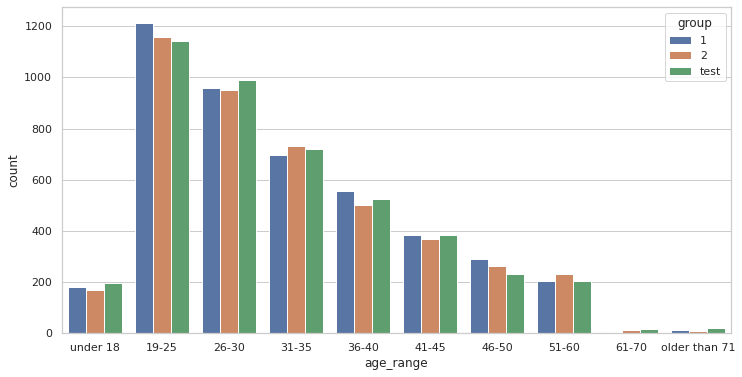

In [65]:
df['age_range']= df.age.apply(age_range)
sns.countplot(data=df, x= 'age_range', hue = 'group',
             order=['under 18', '19-25', '26-30', '31-35','36-40','41-45', '46-50', '51-60', '61-70','older than 71'])
#plt.title('Средний чек на покупателя в контрольной и тестовой группах')
#plt.xlabel('Группа')
#plt.ylabel('Средний чек')

Распределение по возрасту примерно одинаковое, самая активная возрастная группа - пользователи 19-25 лет.   


## Целевые метрики
А/В-тест был направлен на повышение количества покупок премиум-статусов в определенных странах, значит, основная целевая метрика - рост выручки в тестовой группе у новых пользователей из нескольких стран.
Метрики, на которые будем смотреть:  
**ARPU** - средняя выручка на пользователя  
**ARPPU** - общий доход/количество платящих пользователей  
**Конверсия в подписку после пробного периода (CR)**- количество пользователей с подписками по типу продукта "coins", "other_type"/количество пользователей с подпиской "trial_premium"   


### Исследование данных на наличие ошибок

Есть ли в данных несоответствия: имеется дата регистрации и дата оплаты, последняя не должна производиться раньше.    
Также, можно посмотреть, у всех ли пользователей с премиум статусом присутствует информация об оплате

In [66]:
#у кого есть премиум, но нет данных о выручке
df.query('total_revenue == 0 & is_premium == 1  ').uid.nunique()


111

In [67]:
#есть ли данные, где регистрация прошла после оплаты
payment_before_registration = df.query('joined_at > paid_at')
payment_before_registration.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,age_range
210,891973917,25,125,0.0,France,"2,3,5,6,7,9,10,12,13,14,16,18,20,22",1,22,28,8,...,1.0,6344,2017-10-23 18:31:00,2017-02-11 19:03:00,6344.0,147.0,promo_09,premium_no_trial,1,19-25
293,892421277,22,446,62.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,35,130,...,1.0,60333,2017-10-14 13:05:00,2017-02-11 02:12:00,12610.0,19.0,empty_likes,coins,1,19-25
658,892120956,58,183,0.0,Belgium,"1,6,12,13,14,15,16,18,19",1,36,54,278,...,1.0,3042,2017-10-20 18:20:00,2017-05-11 13:43:00,3042.0,68.0,none,premium_no_trial,1,51-60
1007,891693753,24,311,50.0,Turkey,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,18,40,478,...,1.0,13026,2017-10-29 15:24:00,2017-04-11 20:45:00,5304.0,19.0,empty_likes,coins,1,19-25
1009,891693753,24,311,50.0,Turkey,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,18,40,478,...,1.0,13026,2017-10-29 15:24:00,2017-06-11 22:30:00,3432.0,147.0,promo_09,premium_no_trial,1,19-25


In [68]:
print (f'В датафрейме {payment_before_registration.shape[0]} некорректных записей, где дата регистрации позже даты оплаты.')

В датафрейме 162 некорректных записей, где дата регистрации позже даты оплаты.


Сбой произошел везде, или только в определенной стране?

In [69]:
countries= payment_before_registration.groupby('country', as_index=False)\
.agg({'joined_at': 'count', 'paid_at':'count'})\
.sort_values('joined_at', ascending=False)
countries

,country,joined_at,paid_at
17,United States of America,43,43
6,France,24,24
9,Italy,19,19
16,United Kingdom (Great Britain),10,10
0,Argentina,10,10
5,Chile,9,9
12,Spain,9,9
4,Canada,6,6
15,United Arab Emirates,6,6
3,Belgium,5,5


In [70]:
print (f'Сбой произошел в {countries.shape[0]} странах из {df.country.nunique()}.')

Сбой произошел в 18 странах из 72.


In [71]:
#В какие даты были совершены ошибки? Для этого преобразуем колонки в дату без времени
payment_before_registration['joined_at']=pd.to_datetime(payment_before_registration['joined_at']).dt.date
payment_before_registration['paid_at']=pd.to_datetime(payment_before_registration['paid_at']).dt.date


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
payment_before_registration['joined_at'].value_counts().to_frame().reset_index()

,index,joined_at
0,2017-10-29,31
1,2017-10-30,24
2,2017-10-31,21
3,2017-10-25,14
4,2017-10-26,13
5,2017-10-21,12
6,2017-10-27,7
7,2017-10-20,6
8,2017-10-17,6
9,2017-10-28,5


In [73]:
payment_before_registration['paid_at'].value_counts().to_frame().reset_index()

,index,paid_at
0,2017-04-11,24
1,2017-02-11,22
2,2017-03-11,20
3,2017-05-11,19
4,2017-06-11,17
5,2017-10-11,16
6,2017-01-11,15
7,2017-08-11,11
8,2017-09-11,9
9,2017-07-11,9


Все даты регистрации в данных с ошибками произошли в октябре.   
Чтобы понять, исключать эти записи или нет, можно посмотреть, в какое время проводился А/В-тест, и если эти данные входят во временные рамки, оставим их.
А/В-тест начался после введения нового способа оплаты, с появления тестовой группы, возьмем дату первой регистрации в этой группе 

In [74]:
#Даты проведения эксперимента: 
print (f'А/В-тест был проведен с {df_test.joined_at.min()} по {df.paid_at.max()}')


А/В-тест был проведен с 2017-01-11 03:07:00 по 2017-12-11 23:28:00


Эксперимент проводился с января по декабрь 2017 года, данные с ошибками входят в этот период, оставим их.

In [75]:
#Есть ли даты, которые не входят в данный диапазон:
df.query('joined_at < "2017-01-11"')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,age_range
522,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,...,1.0,26,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,1,26-30
523,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,...,1.0,26,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,1,26-30
524,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,...,1.0,26,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,1,26-30


In [76]:
df.query('joined_at > "2017-12-11"')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,age_range


### Выводы
1. В датафрейме присутствует 162 записи, где дата регистрации записана позже даты оплаты. Общая выручка в этих данных составляет 11,47% от всей выручки. Везде в дате регистрации присутствует октябрь, а в дате оплаты - 11 число

### A/A тест
Наличие двух контрольных групп предполагает проведение А/А теста. Он нужен для того, чтобы оценить, действительно ли пользователи разделились по группам случайным образом (корректно ли работает система сплитования). 

В обеих группах не должно быть статистически значимых различий, они должны быть однородны по размеру и по набору данных. 
Проверим, есть ли различия в распределении пользователей по странам, полу, наличию премиум-статуса, целевым метрикам, типу продукта.

**Нулевая гипотеза:** Группы 1 и 2 однородны.     
**Альтернативная гипотеза:** Группы 1 и 2 неоднородны 

### Распределение по стране
Одинаковое ли распределение в группах по странам? При несоответствии, подкрасим значения 

In [77]:
country_control = pd.crosstab(df_control.country, df.group).style.highlight_min()
country_control

group,1,2
country,,
Algeria,2,0
Argentina,404,405
Armenia,1,0
Australia,50,52
Austria,0,4
Belarus,0,1
Belgium,108,94
Burkina Faso,1,0
Canada,139,136


Распределение по странам не совсем однородное, только 27 стран есть и в 1 группе, и во 2.

In [78]:
#Проверим, применив хи-квадрат 
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_control.country, df.group))

In [79]:
if p <= 0.05:
    print('Отклоняем нулевую гипотезу')
else:
    print('Не отклоняем нулевую гипотезу')

Не отклоняем нулевую гипотезу


### Распределение по полу


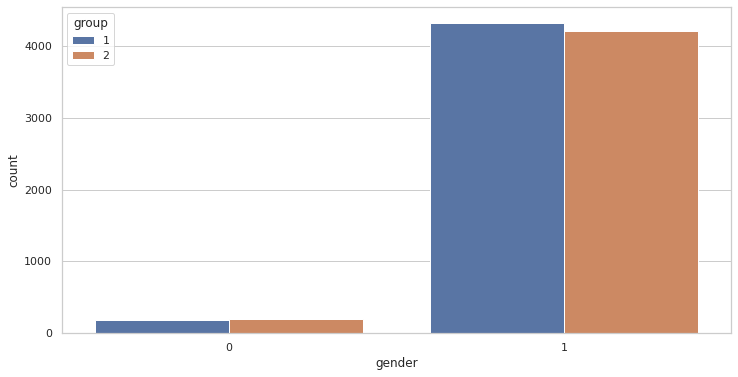

In [80]:
sns.countplot(data=df_control, x="gender", hue="group")

In [81]:
#Проверка гипотезы
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_control.gender, df.group))
if p <= 0.05:
    print('Отклоняем нулевую гипотезу')
else:
    print('Не отклоняем нулевую гипотезу')

Не отклоняем нулевую гипотезу


### Распределение по наличию премиум-статуса

In [82]:
pd.crosstab(df.group, [df_control.was_premium, df_control.is_premium] )

was_premium   0.0  1.0     
is_premium    0.0  0.0  1.0
group                      
1            3917  263  323
2               0    0  308

In [83]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.group, [df_control.was_premium, df_control.is_premium] ))
if p <= 0.05:
    print('Отклоняем нулевую гипотезу')
else:
    print('Не отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


### Распределение по типу продукта

In [84]:
pd.crosstab(df_control.product_type, df.group)

group,1,2
product_type,,
coins,137,120
other_type,46,43
premium_no_trial,106,107
trial_premium,67,53


In [85]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_control.product_type, df.group))
if p <= 0.05:
    print('Отклоняем нулевую гипотезу')
else:
    print('Не отклоняем нулевую гипотезу')

Не отклоняем нулевую гипотезу


### Распределение по метрикам. ARPU

In [86]:
#df_control['revenue'].fillna(0, inplace=True)
#df_control = df_control.query("total_revenue > 0")

In [87]:
arpu_1 = np.mean(users_control_1.total_revenue).round(2)
arpu_2 = np.mean(users_control_2.total_revenue).round(2)
print(f"ARPU в группе 1: {arpu_1}\n"
      f"ARPU в группе 2: {arpu_2}")

ARPU в группе 1: 594.76
ARPU в группе 2: 450.38


В первой группе ARPU значительно больше.

In [88]:
pg.homoscedasticity(data=df_control, dv="total_revenue", group="group")

,W,pval,equal_var
levene,21.939605,0.000003,False


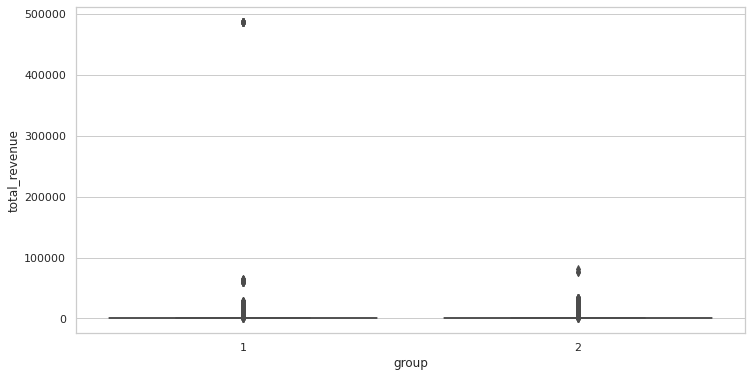

In [89]:
sns.boxplot(data=df_control, x="group", y="total_revenue")

#plt.title('Средний чек на покупателя в контрольной и тестовой группах')
#plt.xlabel('Группа')
#plt.ylabel('Средний чек')

In [90]:
#Посмотрим на этот выброс
df_control.query('group == "1"').total_revenue.max()

486330

In [91]:
df_control.query('total_revenue == 486330')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
1463,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19.0,gifts,coins,1
1464,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,1
1465,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,1
1466,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,1
1467,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type,1
1468,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 01:38:00,2017-10-16 22:35:00,31525.0,19.0,menu,coins,1
1469,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 01:38:00,2017-10-16 18:42:00,31525.0,19.0,fans,coins,1
1470,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 01:38:00,2017-10-16 22:39:00,19773.0,146.0,menu,coins,1
1471,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 01:38:00,2017-10-16 02:08:00,31525.0,19.0,gifts,coins,1
1472,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147.0,no_sympathy,premium_no_trial,1


Похоже, что это просто человек, которому очень нравится данное приложение.


Что можно сделать с выбросами: 
1. Прологарифмировать значения
2. Удалить максимальные значия - топ n% пользователей 
3. Применить непараметрический тест - критерий Манна-Уитни или бутстрап



In [92]:
#Проверка на нормальность распределений, как и ожидалось - распределения ненормальные
pg.normality(data=df_control, dv="total_revenue", group="group", method="normaltest")

,W,pval,normal
1,8486.447809,0.0,False
2,5804.160721,0.0,False


In [93]:
# попробуем применить логарифмирование 
df_control['total_revenue_log'] = np.log(df_control.query('total_revenue > 0').total_revenue)


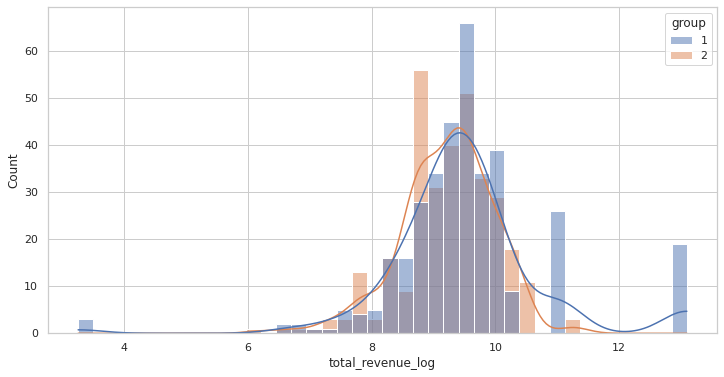

In [95]:
sns.histplot(data=df_control, x= 'total_revenue_log', hue='group', kde=True)

In [96]:
#еще одна проверка на нормальность 
pg.normality(data=df_control, dv="total_revenue_log", group="group", method="normaltest")

,W,pval,normal
1,50.943533,8.664677e-12,False
2,25.006070,3.715360e-06,False


Логарифмирование не очень помогло в данной ситуации. Можно попробовать применить U-критерий Манна-Уитни. Для данного метода не нужно требование о нормальности распределения, и он устойчив к выбросам, однако, для бизнеса этот критерий не всегда понятен 

In [97]:
# U-критерий Манна-Уитни
pg.mwu(x=df_control.query("group == '1'").total_revenue, 
         y=df_control.query("group == '2'").total_revenue)

,U-val,alternative,p-val,RBC,CLES
MWU,9968188.5,two-sided,0.269387,-0.006217,0.503108


Получили уровень значимости - 0,269 - средняя сумма рангов статистически значимо не различается, значит, можно оставить нулевую гипотезу.

In [98]:
#outlier_gr_1_filter = np.quantile(gr_1['total_revenue'], 0.99)
#outlier_gr_2_filter = np.quantile(gr_2['total_revenue'], 0.99)
    
#gr_1 = gr_1[gr_1 < outlier_gr_1_filter]
#gr_2 = gr_2[gr_2 < outlier_gr_2_filter]


In [99]:
gr_1 = df_control[df_control.group == '1']
gr_2 = df_control[df_control.group == '2']

In [100]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

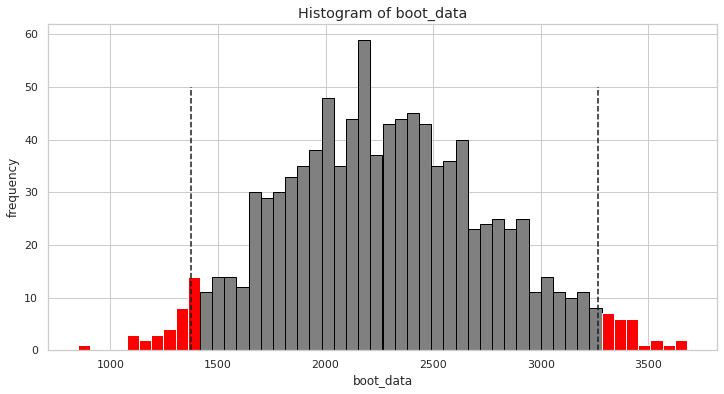

In [101]:
booted_data = get_bootstrap(gr_1.total_revenue, gr_2.total_revenue)

In [102]:
if booted_data["p_value"] <= 0.05:
    print('Отклоняем нулевую гипотезу')
else:
    print('Не отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


In [103]:
booted_data["quants"]

,0
0.025,1374.390284
0.975,3268.265029


### Распределение по метрикам. ARPPU

In [104]:
arppu_1 = df_control.query('group == "1" ').total_revenue.sum() / df_control.query('group == "1" & is_premium == 1').uid.nunique()
arppu_2 = df_control.query('group == "2" ').total_revenue.sum() / df_control.query('group == "2" & is_premium == 1').uid.nunique()
print(f"ARPPU в группе 1: {arppu_1.round(2)}\n"
      f"ARPPU в группе 2: {arppu_2.round(2)}")

ARPPU в группе 1: 75919.46
ARPPU в группе 2: 22081.76


In [105]:
#pg.homoscedasticity(data=df_control, dv="total_revenue", group="group")

In [106]:
#pg.ttest(x=df_control.query("group == '1'").total_revenue_log, 
#         y=df_control.query("group == '2'").total_revenue_log)

In [107]:
gr_1 = df_control[df_control.group == '1']
gr_2 = df_control[df_control.group == '2']

In [108]:
bootstrap((gr_1.total_revenue, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=2439.5906133184344, high=4344.58585158041), standard_error=478.03563309434975)

Попробуем убрать топ 1% пользователей из групп - определим 99 квантиль и уберем всех, у кого выручка больше этого значения.



Уровень значимости - 0.58, можно оставить нулевую гипотезу.


In [109]:
#import scipy.stats as st

### A/B-тест
В задании указывается, что изменения применили для **новых** пользователей из **нескольких стран** (при этом стоимость пробного периода не изменилась).   
Какого пользователя можно считать новым:   
1) кто купил подписку впервые (и это не пробная подписка)   
2) кто купил первую подписку после пробной   
Как найти те несколько стран, где ввели изменения

In [110]:
#Есть ли пользователи, которые купили любую премиум-подписку, но ни разу не зашли в приложение
fallen_off = df_control_1.query('visit_days == 0 and product_type != 0')\
.groupby('product_type', as_index=False)\
.agg({'uid':'count'})\
.sort_values('uid', ascending=False)
fallen_off
#таким пользователям можно прислать напоминание/предложить бонусы 

,product_type,uid
3,trial_premium,9
2,premium_no_trial,4
0,coins,3
1,other_type,1
